In [1]:
from tqdm import tqdm
import treescope as ts
import matplotlib.pyplot as plt
import torch


class Logger(dict):
    def log(self, vals={}, *, pbar=None, prefix="", suffix="", **kwargs):
        vals = {**vals, **kwargs}
        for k, v in vals.items():
            self.setdefault(k, []).append(v)
        if pbar is not None:
            vals = {prefix + k + suffix: f"{v:.6f}" for k, v in vals.items()}
            pbar.set_postfix(**vals)

In [2]:
from data import DNADataset
from vae import SequenceVAE
dataset = DNADataset("hf://datasets/Zehui127127/latent-dna-diffusion/sequence.csv")
model = SequenceVAE(in_dim=5, dim=32)
ts.display(model)

Loading data from hf://datasets/Zehui127127/latent-dna-diffusion/sequence.csv...
Processing data...
Done!


In [3]:
device = torch.device("cuda:1")
model = model.to(device=device)

optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64)#, shuffle=True)

logger = Logger()
cycles = 5
epochs = 20
for cycle in range(cycles):
    for j in range(epochs):
        for i, X in enumerate(pbar := tqdm(dataloader, desc=f"Cycle {cycle} Epoch {j}")):
            cycle_progress = (j * len(dataloader) + i + 1) / (epochs * len(dataloader))
            beta = min(1.0, 2*cycle_progress)
            logger.log(beta=beta)

            X = X.to(device=device, non_blocking=True)
            loss_recon, loss_kl = model.losses(X)
            
            optimizer.zero_grad()
            (loss_recon + beta * loss_kl).backward()
            optimizer.step()

            logger.log(recon=loss_recon.item(), kl=loss_kl.item(), pbar=pbar)

    torch.save(model, f"model_test_cycle_{cycle}.pth")

Cycle 0 Epoch 0:   0%|          | 0/2487 [00:00<?, ?it/s]

Cycle 0 Epoch 3:   8%|▊         | 205/2487 [00:11<02:13, 17.15it/s, kl=0.419475, recon=0.437096]


KeyboardInterrupt: 

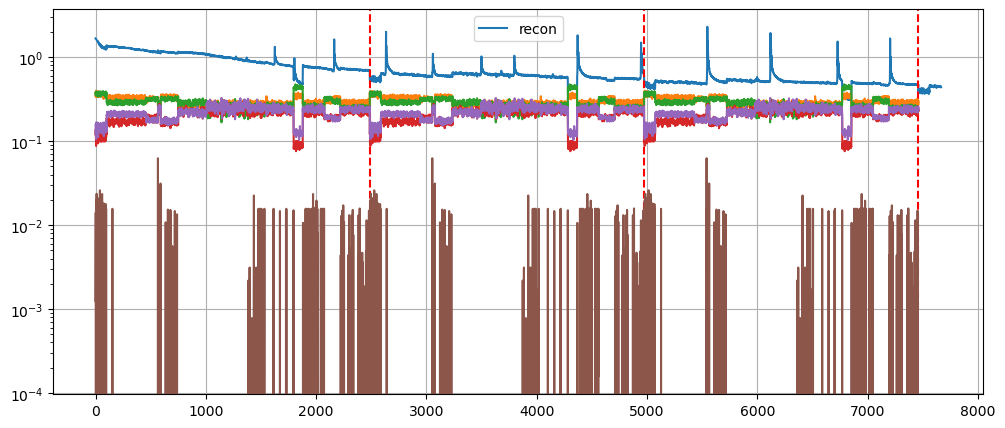

In [16]:
plt.figure(figsize=(12, 5))
plt.semilogy(logger["recon"], label="recon")
#plt.semilogy(logger["kl"], label="kl")
#plt.plot(logger["beta"], label="beta")
plt.vlines([len(dataloader)*i for i in range(1, 4)], 1e-3, 1e2, color="red", linestyle="--")
plt.legend()
plt.grid()

a = [el.mean(0)[-100:].mean(0).T for el in dataloader]*3
plt.plot(a)
plt.show()